In [4]:
import numpy as np 
import sys
import os
import re
def set_path():
    if sys.platform == 'darwin':
        print("Current system is macOS")
        main_fold_path = '/Users/shanxiafeng/Documents/Project/Research/fnirs-prognosis/code/fnirs-treatment-response-prediction'
    elif sys.platform == 'linux':
        print("Current system is Ubuntu")
        main_fold_path = '/home/jy/Documents/fnirs/treatment_response/fnirs-depression-deeplearning'
    else:
        print("Current system is neither macOS nor Ubuntu")
    os.chdir(main_fold_path)
    
set_path()    


import pandas as pd 
def get_best_acc_epoch(csv_file):
    df = pd.read_csv(csv_file)
    index_of_best_acc = df['val_accuracy'].argmax()
    return index_of_best_acc

import glob 

def delete_files_starting_with(directory, prefix):
    pattern = os.path.join(directory, '*' + prefix + '*') 
    files_to_delete = glob.glob(pattern)
    for file in files_to_delete:
        try: 
            os.remove(file)
        except Exception as e:
            print(e)
        

model_name = 'cnn_transformer'
config_name = 'skf_v0mdd_classification_jamba'
dataset = 'diagnosis514'
model_config_dict = {
    # 'jamba_multimodal':[ f'eval{i}mdd_classification_jamba' for i in range(2)],
    # 'cnn_transformer': [f'eval{i}mdd_classification_jamba_subject_110_hb_simple_all_1d_SPECIFY_FOLD_5_nor' for i in range(1, 6)],
    # 'mamba': [f'eval_{i}mdd_classification_mamba_subject_all_hb_simple_all_1d_SPECIFY_FOLD_2_nor' for i in range(1, 11)],
    # 'jamba_hybrid': [f'eval_{i}mdd_classification_mamba_subject_all_seq_ch_hb_data_1d_SPECIFY_FOLD_5_nor_with_glbpool' for i in range(1,4)],
    'cnn_transformer': [f'eval_{i}mdd_classification_mamba_subject_all_seq_ch_hb_simple_all_1d_SPECIFY_FOLD_3_holdout_4_nor' for i in range(1,11)],

    # 'mamba': [f'eval_{i}mdd_classification_mamba_subject_all_seq_ch_hb_data_1d_SPECIFY_FOLD_5_nor_with_glbpool' for i in range(1,3)],

    # 'jamba': [f're{i}mdd_classification_jamba_subject_110_hb_simple_all_1d_SPECIFY_FOLD_5_nor' for i in range(1, 6)] \
    #     + [f'eval{i}mdd_classification_jamba_subject_110_hb_simple_all_1d_SPECIFY_FOLD_5_nor' for i in range(1, 6)] \
    #     + [f'eval{i}mdd_classification_jamba_subject_110_hb_simple_all_1d_SPECIFY_FOLD_5_nor_chkpt' for i in range(1, 6)] \
    #     + ['re_eval3_1mdd_classification_jamba_subject_110_hb_simple_all_1d_SPECIFY_FOLD_5_nor'] \
    #     + ['t11mdd_classification_jamba_subject_250_hb_simple_all_1d_SPECIFY_FOLD_AND_HOLD_5_nor'],
    #      + [f'eval{i}mdd_classification_jamba_subject_110_hb_simple_all_1d_SPECIFY_FOLD_5_nor' for i in range(1, 6)],
    # 'jamba': ['eval1mdd_classification_jamba_subject_483',
    #           'eval2mdd_classification_jamba_subject_483'],
    # 'jamba': np.flip(['skf_v0mdd_classification_jamba', 
    #           'skf_v1_2layersmdd_classification_jamba', 
    #           'skf_v1_1layers_64_modelstatesmdd_classification_jamba',
    #           'skf_v2_sin_lrmdd_classification_jamba',
    #           'skf_v4_1e5_lrbeginmdd_classification_jamba',
    #           'skf_v5_no_mean_premdd_classification_jamba',
    #           'skf_v6_3layers_256_input_dimsmdd_classification_jamba',
    #           'skf_v7_3layers_256dims_9blocksmdd_classification_jamba',
    #           'skf_v8_2layersmdd_classification_jamba',
    #           'skf_v9_4layersmdd_classification_jamba',
    #           'skf_s0mdd_classification_jamba',
    #           'skf_s1_conv1d_longmdd_classification_jamba',
    #           'skf_s2_conv1d_1000epochs_1e9lrmdd_classification_jamba',
    #           'skf_s3_1000epochs_1e6lrmdd_classification_jamba',
    #           'skf_s4_1e-5lrmdd_classification_jamba',
    #           'skf_s5mdd_classification_jamba',
    #           'skf_s6_replicationmdd_classification_jamba',
    #           'skf_s7_replicat_5000warmupmdd_classification_jamba',
    #           'skf_s8_valaccmdd_classification_jamba',
    #           'skf_s9_valloss_50patiencesmdd_classification_jamba',
    #           'skf_s10_300patiencesmdd_classification_jamba']),
    # 'mamba': ['skf_v0mdd_classification_mamba']
}
num_of_k_fold = 3

validation_name = f'SKF_holdout/stratified_nested_{num_of_k_fold}_CV_fold'

# reading the last index of result
# def find_path_acc(path):
#     with open(path, 'r') as f:
#         acc = f.read()
#     acc = acc.split('\n')[-2]
#     acc = re.findall(r'accuracy: (\d+\.\d+)', acc)[0]
    
#     return np.float(acc)

def find_path_metrics(path):
    with open(path, 'r') as f:
        content = f.read()

    accuracy = re.findall(r'accuracy: (\d+\.\d+)', content)[0]
    sensitivity = re.findall(r'sensitivity: (\d+\.\d+)', content)[0]
    specificity = re.findall(r'specificity: (\d+\.\d+)', content)[0]
    auc = re.findall(r'AUC: (\d+\.\d+)', content)[0]

    # Convert the extracted strings to floats
    accuracy = float(accuracy)
    sensitivity = float(sensitivity)
    specificity = float(specificity)
    auc = float(auc)
    
    return accuracy, sensitivity, specificity, auc
from utils.fnirs_utils import print_md_table_val_test_AUC
def read_model_config_result(model_name, config_name, validation_name='SKF_holdout/stratified_nested_10_CV_fold', num_of_k_fold=10):
    test_metrics = []
    val_metrics = []
    index_best = []
    for k in range(num_of_k_fold):
        path = f'results/{model_name}/{dataset}/{config_name}/{validation_name}-{k}' 
        fold_test_acc = find_path_metrics(path + '/test_acc.txt')
        fold_val_acc = find_path_metrics(path + '/val_acc.txt')
        fold_index_best = get_best_acc_epoch(path + '/history.csv')
        index_best.append(fold_index_best)
        test_metrics.append(fold_test_acc)
        val_metrics.append(fold_val_acc)

        # delete checkpoint files, in case the space is not enough
        delete_files_starting_with(path, 'checkpoint')
    head_print = True if config_name[:7] == 'skf_s10' else False
    print_md_table_val_test_AUC(config_name[:7], np.mean(test_metrics, axis=0), np.mean(val_metrics,axis=0), print_table_header=head_print, already_balanced_accuracy=False)
    # print(val_metrics)
    # print('model_name:', model_name, config_name)
    # print('test_acc:', np.mean(test_metrics))
    # print('val_acc:', np.mean(val_metrics))
    # print('index_best:', np.mean(index_best))
    return np.mean(test_metrics, axis=0), np.mean(val_metrics,axis=0)

all_test_metrics = []
all_val_metrics = []
from utils.utils_mine import plot_evaluation_metrics_header
plot_evaluation_metrics_header()
for model_name, config_names in model_config_dict.items():
    for config_name in config_names:
        test_metrics, val_metrics = read_model_config_result(model_name, config_name, validation_name, num_of_k_fold)
        all_test_metrics.append(test_metrics)
        all_val_metrics.append(val_metrics)

Current system is Ubuntu
| Model Name | Testing Set |             |             |             | Validation Set |             |             |             |
|------------|-------------|-------------|-------------|-------------|-------------|-------------|-------------|-------------|
|            | Balanced Accuracy | Sensitivity | Specificity | AUC | Balanced Accuracy | Sensitivity | Specificity | AUC |
| eval_1m   | 59.2723  | 46.2370  | 72.3077  | 62.4610  | 59.8845  | 46.0317  | 73.7373  | 59.8243  |
| eval_2m   | 57.7170  | 34.4083  | 81.0257  | 60.2360  | 58.6580  | 36.5080  | 80.8080  | 59.4797  |
| eval_3m   | 56.8775  | 42.4730  | 71.2820  | 62.0140  | 62.2415  | 49.7357  | 74.7473  | 63.8850  |
| eval_4m   | 58.5030  | 46.2367  | 70.7693  | 61.1787  | 61.9288  | 47.0900  | 76.7677  | 59.0067  |
| eval_5m   | 63.5525  | 65.0537  | 62.0513  | 55.2770  | 66.2457  | 70.3703  | 62.1210  | 57.4473  |
| eval_6m   | 56.0713  | 40.8603  | 71.2823  | 61.6583  | 56.1688  | 38.0953  | 74.24

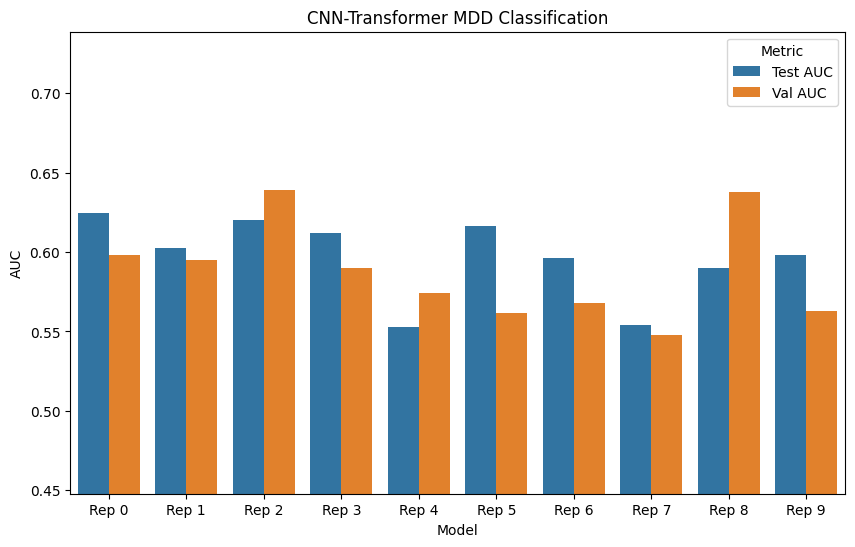

: 

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns
# Example data

def compare_metric_many_itr(test_metric, val_metric, metric_name, title_name):
    data = {
        'Name': [f'Rep {i}' for i in range(len(test_metric))],
        f'Test {metric_name}': test_metric,
        f'Val {metric_name}': val_metric
    }

    # Create a DataFrame
    df = pd.DataFrame(data)

    # Melt the DataFrame to long-form for seaborn
    df_melted = df.melt(id_vars='Name', value_vars=['Test AUC', 'Val AUC'], var_name='Metric', value_name='AUC')

    # Create the plot
    plt.figure(figsize=(10, 6))
    sns.barplot(data=df_melted, x='Name', y='AUC', hue='Metric')
    plt.title('Comparison of Test AUC and Validation AUC')
    plt.ylabel('AUC')
    plt.xlabel('Model')
    plt.legend(title='Metric')
    plt.title(title_name)
    min_val = min(df_melted['AUC']) - 0.1
    max_val = max(df_melted['AUC']) + 0.1
    
    plt.ylim(min_val, max_val)  # Set y-axis limits for better visualization
    plt.show()

test_auc = np.array(all_test_metrics)[:, -1]
val_auc = np.array(all_val_metrics)[:, -1]
test_auc, val_auc
title_name = 'CNN-Transformer MDD Classification'
compare_metric_many_itr(test_auc, val_auc, 'AUC', title_name)

In [15]:
# read the best acc and its corresponding epoch 
import pandas as pd 
def get_best_acc_epoch(csv_file):
    df = pd.read_csv(csv_file)
    index_of_best_acc = df['val_accuracy'].argmax()
    return index_of_best_acc
# csv_file = '/home/jy/Documents/fnirs/treatment_response/fnirs-depression-deeplearning/results/jamba/diagnosis514/skf_s2_conv1d_1000epochs_1e9lrmdd_classification_jamba/SKF_holdout/stratified_nested_10_CV_fold-9/history.csv'
# df = pd.read_csv(csv_file)
# index_of_best_acc = df['val_accuracy'].argmax()
# index_of_best_acc